In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import time
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [2]:
image_size = 112
batch_size = 16

train_dir = r"/kaggle/input/mango-leaf/mango-prepo/train"
val_dir = r"/kaggle/input/mango-leaf/mango-prepo/val"
test_dir = r"/kaggle/input/mango-leaf/mango-prepo/test"


datagen_train = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,
                                  horizontal_flip=True,  vertical_flip=False)
datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=train_dir, target_size=(image_size, image_size),
                                                    batch_size=batch_size, shuffle=True)
val_generator = datagen_test.flow_from_directory(directory=val_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)
test_generator = datagen_test.flow_from_directory(directory=test_dir, target_size=(image_size, image_size),
                                                  batch_size=batch_size, shuffle=False)

# Define the number of classes in your dataset
num_classes = train_generator.num_classes

Found 13307 images belonging to 26 classes.
Found 1655 images belonging to 26 classes.
Found 1684 images belonging to 26 classes.


In [4]:
def modelfunction(base):
    
    x = base.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    predictions = tf.keras.layers.Dense(units=num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.02, l2=0.02))(x)
    model = Model(inputs=base.input, outputs=predictions)
    return model 

def get_callbacks(weight):
    
    checkpoint = ModelCheckpoint(weight, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.0002)
    callbacks = [earlystop, checkpoint, learning_rate_reduction]
    return callbacks

def evaluate(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()
    # Generate AUC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Measure inference time
    num_samples = len(generator_test)
    total_time = time.time() - start_time
    inference_time_per_sample = total_time / num_samples
    print("Inference Time: {:.4f} seconds per sample".format(inference_time_per_sample))
    
def model_training(base, weight, epochs):

    model = modelfunction(base)
    print("\n\n\n-------------------- Model Initialized --------------------")
    
    callbacks = get_callbacks(weight)
    metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
               tfa.metrics.CohenKappa(num_classes = num_classes), tfa.metrics.F1Score(num_classes = num_classes)]
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics= metrics)
    
    history = model.fit(train_generator, steps_per_epoch=366 // batch_size, epochs=epochs, callbacks=callbacks, 
                        validation_data= val_generator)
    
    print("\n\n\n-------------------- Evaluation --------------------")
    evaluate(model, val_generator)
    
    return model 

# MobileNet




-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 33.0668 - accuracy: 0.0369 - auc_1: 0.4737 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: -0.0031 - f1_score: 0.0278
Epoch 1: val_loss improved from inf to 32.98758, saving model to Xception.h5
22/22 [==============================] - 58s 1s/step - loss: 33.0668 - accuracy: 0.0369 - auc_1: 0.4737 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: -0.0031 - f1_score: 0.0278 - val_loss: 32.9876 - val_accuracy: 0.0483 - val_auc_1: 0.4997 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_cohen_kappa: 0.0096 - val_f1_score: 0.0380 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 32.7906 - accuracy: 0.0511 - auc_1: 0.5144 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - cohen_kappa: 0.0118 - f1_score: 0.0328
Epoch 2: val_loss improved from 32.98758 to 32.72713, saving model to Xcepti

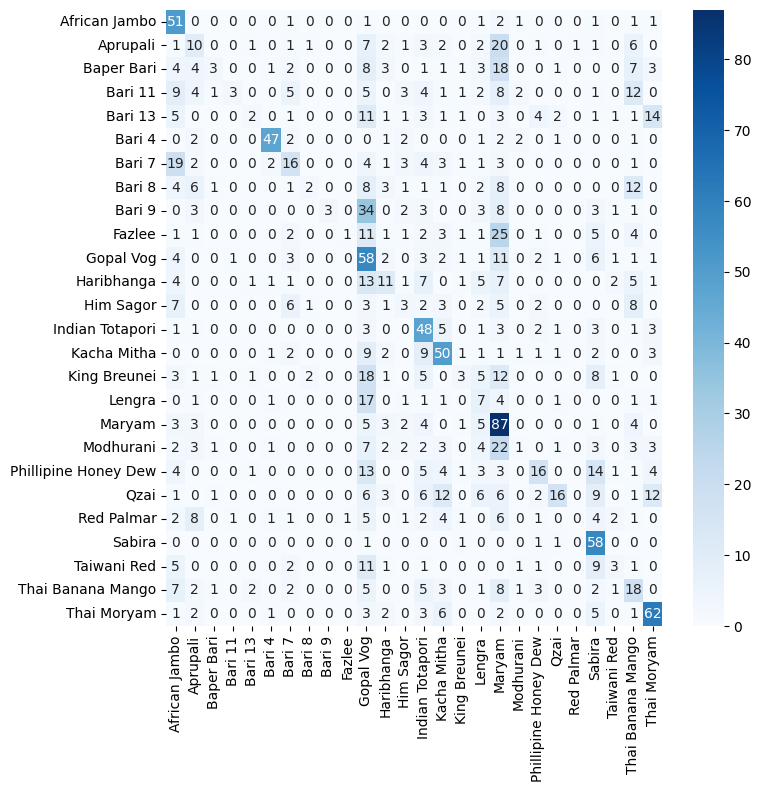

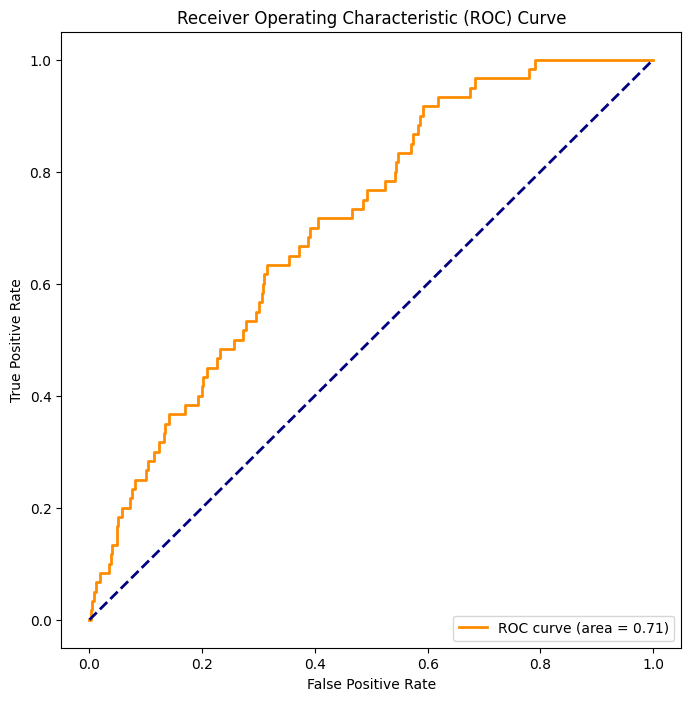

NameError: name 'start_time' is not defined

In [7]:
Xception = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Xception = model_training(Xception,'Xception.h5', 30)

In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

InceptionV3 = model_training(InceptionV3,'InceptionV3.h5', 100)

In [ ]:
DenseNet121 = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

DenseNet121 = model_training(DenseNet121,'DenseNet121.h5', 100)




-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 18.6058 - accuracy: 0.0426 - auc_3: 0.5054 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: 0.0045 - f1_score: 0.0228
Epoch 1: val_loss improved from inf to 18.33830, saving model to Vgg16.h5
22/22 [==============================] - 31s 1s/step - loss: 18.6058 - accuracy: 0.0426 - auc_3: 0.5054 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: 0.0045 - f1_score: 0.0228 - val_loss: 18.3383 - val_accuracy: 0.0465 - val_auc_3: 0.5140 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_cohen_kappa: 0.0177 - val_f1_score: 0.0140 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 18.4018 - accuracy: 0.0426 - auc_3: 0.5113 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - cohen_kappa: 0.0049 - f1_score: 0.0294
Epoch 2: val_loss improved from 18.33830 to 18.12885, saving model to Vgg16.h5
22

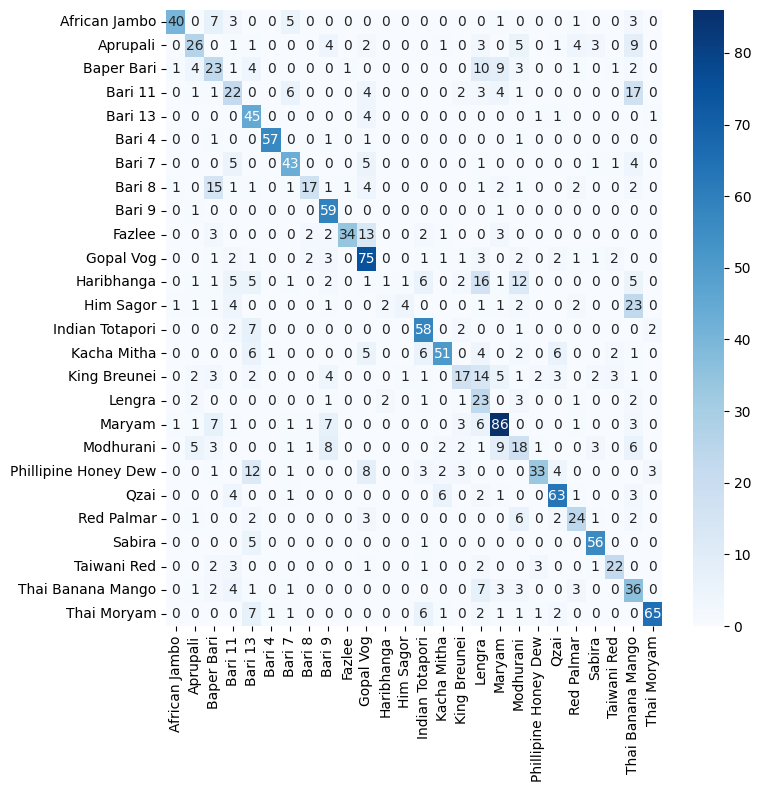

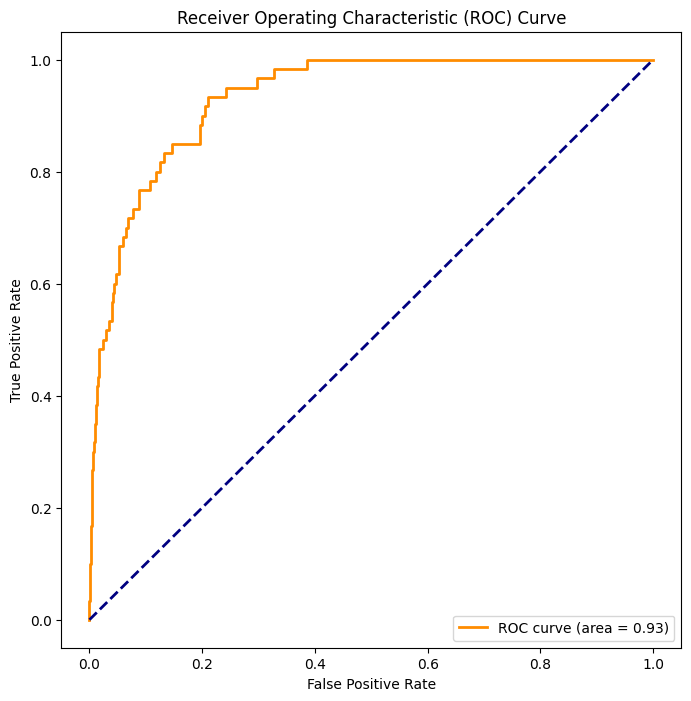

NameError: name 'start_time' is not defined

In [10]:
Vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

Vgg16 = model_training(Vgg16,'Vgg16.h5', 30)

In [9]:
# ResNet50V2 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

# ResNet50V2 = model_training(ResNet50V2,'ResNet50V2.h5', 10)

In [7]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# Load the model.
model = tf.keras.models.load_model('ResNet50V2.h5')

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (224, 224))
input_image = tf.expand_dims(input_image, axis=0)
input_image = input_image / 255.0

# Make a prediction on the preprocessed image.
start_time = time.time()
prediction = model.call(input_image)
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


Inference time: 272.37653732299805


219055592/219055592 [==============================] - 1s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 29.2233 - accuracy: 0.0341 - auc_4: 0.5156 - precision_4: 0.5000 - recall_4: 0.0028 - cohen_kappa: -2.4235e-04 - f1_score: 0.0262 
Epoch 1: val_loss improved from inf to 29.05443, saving model to InceptionResNetV2.h5
22/22 [==============================] - 131s 2s/step - loss: 29.2233 - accuracy: 0.0341 - auc_4: 0.5156 - precision_4: 0.5000 - recall_4: 0.0028 - cohen_kappa: -2.4235e-04 - f1_score: 0.0262 - val_loss: 29.0544 - val_accuracy: 0.0302 - val_auc_4: 0.5117 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_cohen_kappa: -0.0072 - val_f1_score: 0.0134 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 28.9842 - accuracy: 0.0597 - auc_4: 0.5457 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - cohen_kappa: 0.0224 - f1_score: 0.0550
Epoch

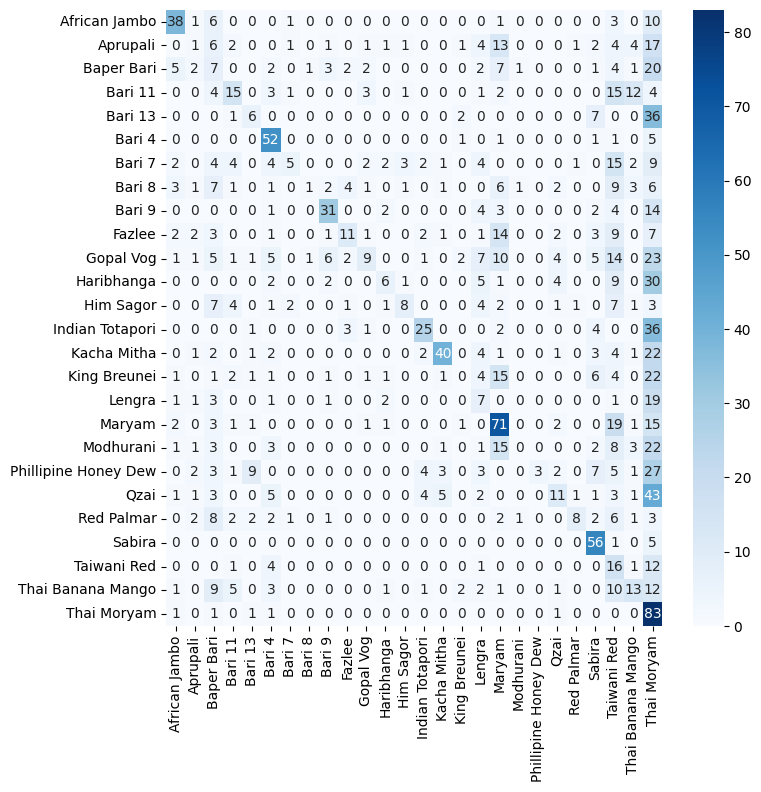

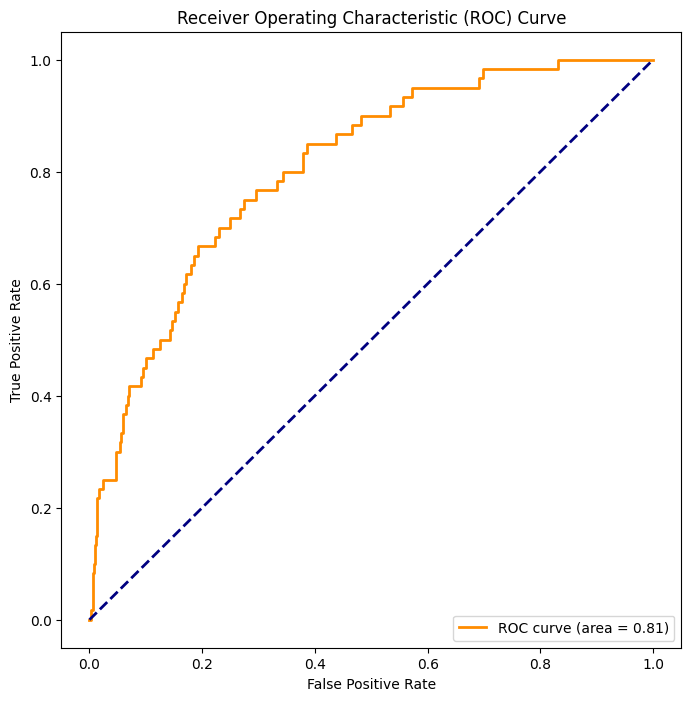

NameError: name 'start_time' is not defined

In [12]:
InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

InceptionResNetV2= model_training(InceptionResNetV2,'InceptionResNetV2.h5', 30)

In [30]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# Load the model.
model = tf.keras.models.load_model('InceptionResNetV2.h5')

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (299, 299))
input_image = tf.expand_dims(input_image, axis=0)
input_image = input_image / 255.0

# Make a prediction on the preprocessed image.
start_time = time.time()
prediction = model.call(input_image)
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


Inference time: 466.4876461029053


In [7]:
# EfficientNetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

# EfficientNetB0 = model_training(EfficientNetB0,'EfficientNetB0.h5', 50)

16705208/16705208 [==============================] - 2s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/50


2023-10-21 12:55:09.048425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 [==============================] - ETA: 0s - loss: 5.3149 - accuracy: 0.2301 - auc_3: 0.4860 - precision_3: 0.1685 - recall_3: 0.0426 - cohen_kappa: 0.0169 - f1_score: 0.2155
Epoch 1: val_loss improved from inf to 5.06475, saving model to EfficientNetB0.h5


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

234698864/234698864 [==============================] - 1s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 33.6143 - accuracy: 0.0398 - auc_5: 0.5154 - precision_5: 0.1250 - recall_5: 0.0085 - cohen_kappa: -5.8031e-04 - f1_score: 0.0374
Epoch 1: val_loss improved from inf to 33.86803, saving model to ResNet152.h5
22/22 [==============================] - 154s 2s/step - loss: 33.6143 - accuracy: 0.0398 - auc_5: 0.5154 - precision_5: 0.1250 - recall_5: 0.0085 - cohen_kappa: -5.8031e-04 - f1_score: 0.0374 - val_loss: 33.8680 - val_accuracy: 0.0363 - val_auc_5: 0.4830 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_cohen_kappa: -6.6912e-04 - val_f1_score: 0.0053 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 33.4297 - accuracy: 0.0312 - auc_5: 0.5350 - precision_5: 0.0588 - recall_5: 0.0028 - cohen_kappa: -0.0069 - f1_score: 0.0260
Epoch 2: val_loss

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


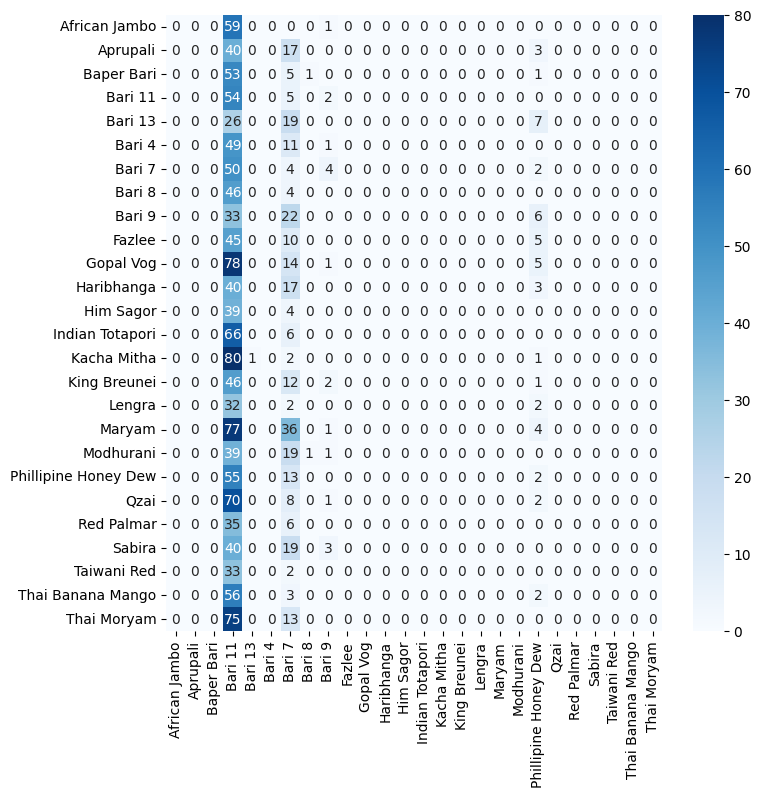

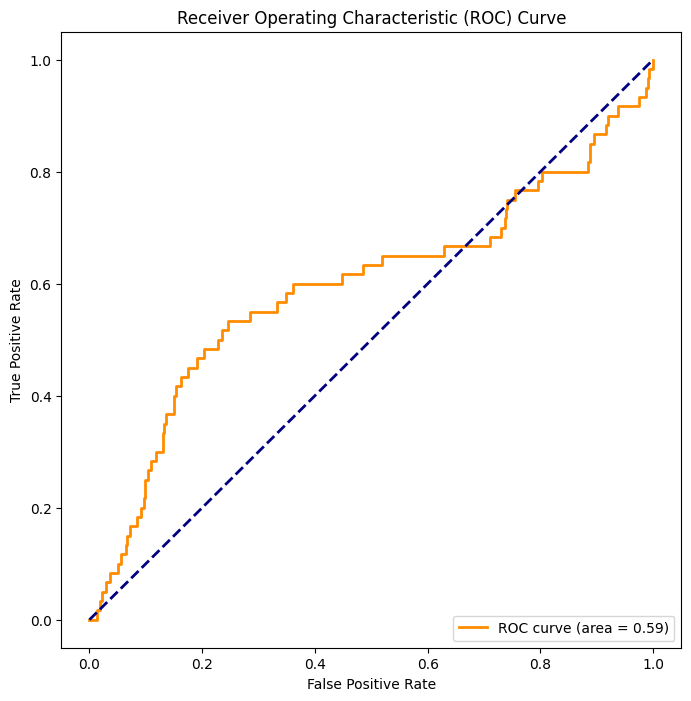

NameError: name 'start_time' is not defined

In [13]:
ResNet152 = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

ResNet152= model_training(ResNet152,'ResNet152.h5', 30)

In [38]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.resnet import ResNet152

# Load the model.
model = tf.keras.models.load_model('ResNet152.h5')

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (224, 224))
input_image = tf.expand_dims(input_image, axis=0)
input_image = input_image / 255.0

# Make a prediction on the preprocessed image.
start_time = time.time()
prediction = model.call(input_image)
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


Inference time: 487.23459243774414





-------------------- Model Initialized --------------------
Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 5.5776 - accuracy: 0.2614 - auc_5: 0.5115 - precision_5: 0.3297 - recall_5: 0.0852 - cohen_kappa: 0.0371 - f1_score: 0.2323
Epoch 1: val_loss improved from inf to 5.46508, saving model to InceptionResNetV2.h5
22/22 [==============================] - 124s 1s/step - loss: 5.5776 - accuracy: 0.2614 - auc_5: 0.5115 - precision_5: 0.3297 - recall_5: 0.0852 - cohen_kappa: 0.0371 - f1_score: 0.2323 - val_loss: 5.4651 - val_accuracy: 0.3254 - val_auc_5: 0.5203 - val_precision_5: 0.2432 - val_recall_5: 0.0269 - val_cohen_kappa: 0.1527 - val_f1_score: 0.3047 - lr: 1.0000e-05
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 5.3802 - accuracy: 0.3665 - auc_5: 0.6212 - precision_5: 0.4571 - recall_5: 0.1364 - cohen_kappa: 0.1545 - f1_score: 0.3220
Epoch 2: val_loss improved from 5.46508 to 5.37096, saving model to InceptionResNetV2.h5
22/22 [=========

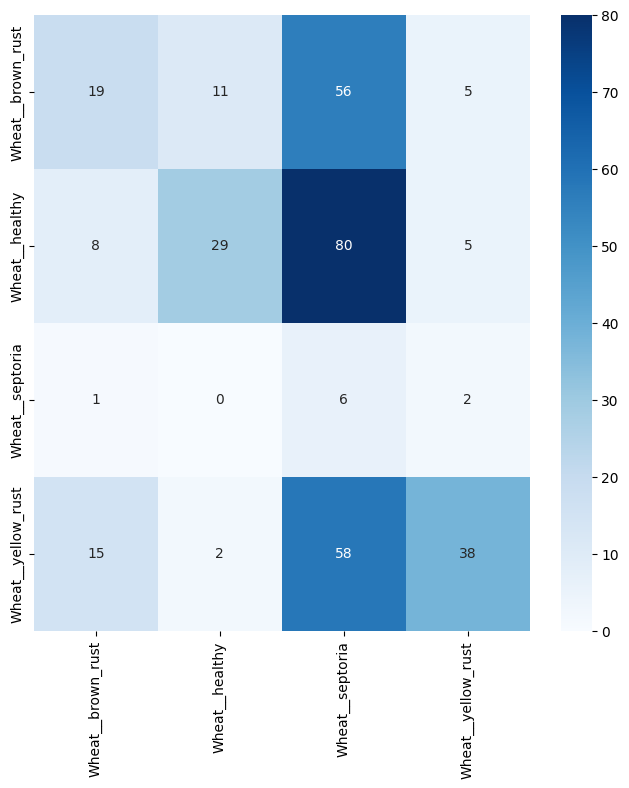

In [9]:
InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

InceptionResNetV2= model_training(InceptionResNetV2,'InceptionResNetV2.h5', 50)

In [15]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# Load the model.
model = tf.keras.models.load_model('InceptionResNetV2.h5')

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (299, 299))
input_image = tf.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)
input_image = input_image.numpy()

# Make a prediction on the preprocessed image.
start_time = time.time()
prediction = model.predict(input_image)
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)

1/1 [==============================] - 3s 3s/step
Inference time: 3459.8782062530518


350926856/350926856 [==============================] - 2s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 25.3382 - accuracy: 0.0256 - auc_6: 0.4598 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - cohen_kappa: -0.0097 - f1_score: 0.0255
Epoch 1: val_loss improved from inf to 24.62199, saving model to ConvNeXtBase.h5
22/22 [==============================] - 123s 2s/step - loss: 25.3382 - accuracy: 0.0256 - auc_6: 0.4598 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - cohen_kappa: -0.0097 - f1_score: 0.0255 - val_loss: 24.6220 - val_accuracy: 0.0224 - val_auc_6: 0.4987 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_cohen_kappa: -0.0151 - val_f1_score: 0.0061 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 24.7592 - accuracy: 0.0455 - auc_6: 0.5241 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - cohen_kappa: 0.0021 - f1_score: 0.0273    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


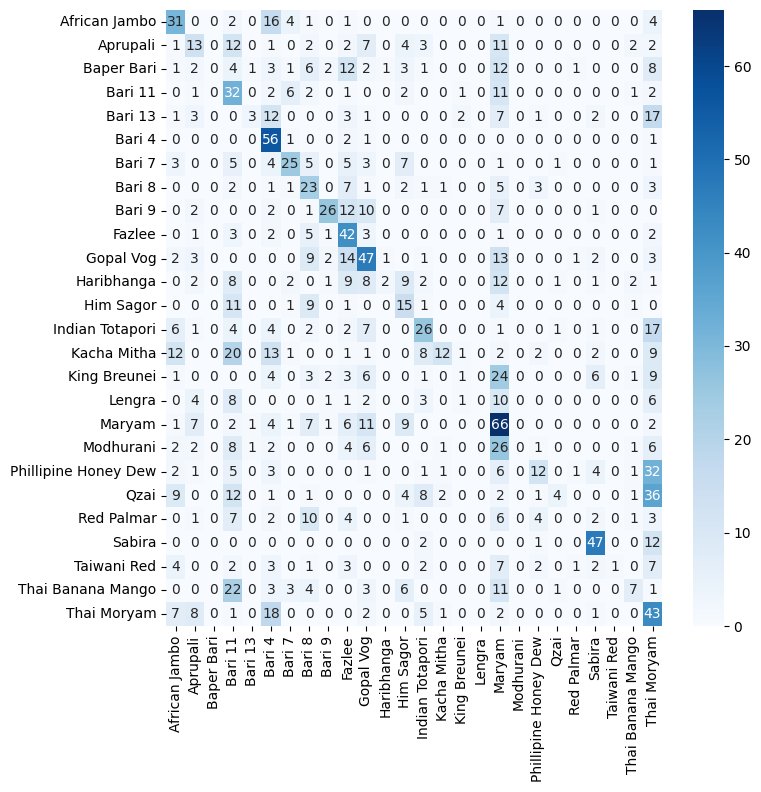

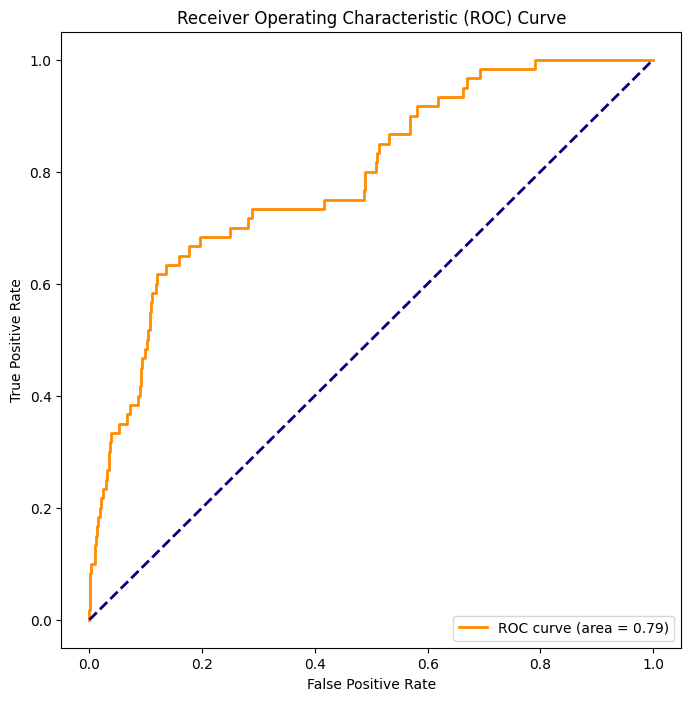

NameError: name 'start_time' is not defined

In [14]:
ConvNeXtBase = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

ConvNeXtBase= model_training(ConvNeXtBase,'ConvNeXtBase.h5', 30)

In [23]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.applications.convnext import ConvNeXtBase
from tensorflow.keras.layers import Masking

# Load the model.
model = ConvNeXtBase(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (299, 299))
input_image = tf.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)
input_image = input_image.numpy()

# Mask the preprocessed input image.
masking_layer = Masking()
masked_input_image = masking_layer(input_image)

# Make a prediction on the masked input image.
start_time = time.time()
prediction = model.call([masked_input_image])
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


Inference time: 4278.687000274658


785596384/785596384 [==============================] - 3s 0us/step



-------------------- Model Initialized --------------------
Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 29.3558 - accuracy: 0.0568 - auc_7: 0.5537 - precision_7: 0.1429 - recall_7: 0.0028 - cohen_kappa: 0.0090 - f1_score: 0.0313      
Epoch 1: val_loss improved from inf to 28.89040, saving model to ConvNeXtLarge.h5
22/22 [==============================] - 134s 2s/step - loss: 29.3558 - accuracy: 0.0568 - auc_7: 0.5537 - precision_7: 0.1429 - recall_7: 0.0028 - cohen_kappa: 0.0090 - f1_score: 0.0313 - val_loss: 28.8904 - val_accuracy: 0.0822 - val_auc_7: 0.5807 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_cohen_kappa: 0.0346 - val_f1_score: 0.0464 - lr: 1.0000e-05
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 29.0294 - accuracy: 0.0682 - auc_7: 0.5739 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - cohen_kappa: 0.0244 - f1_score: 0.0547
Epoch 2: val_lo

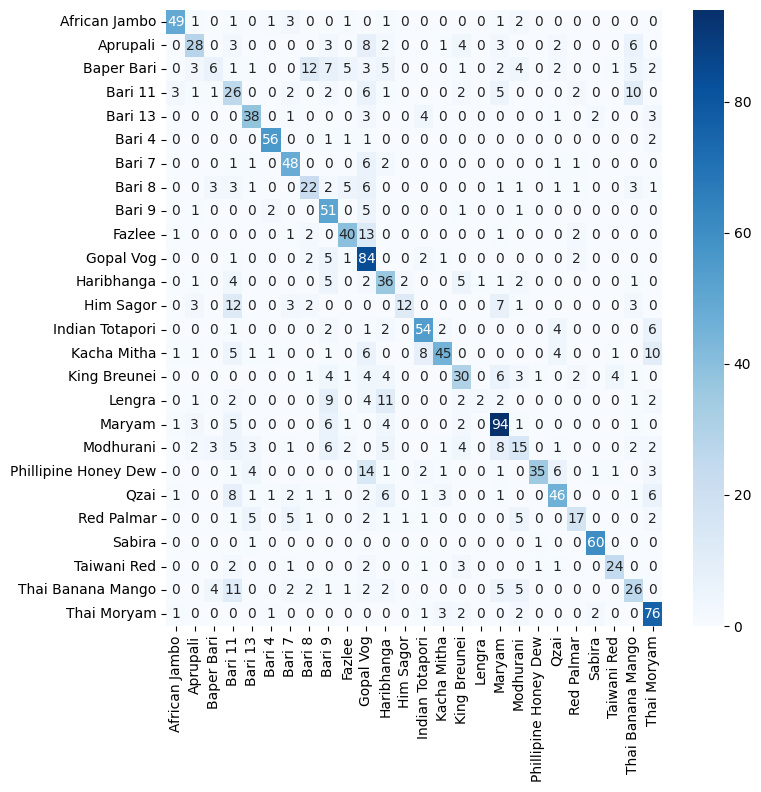

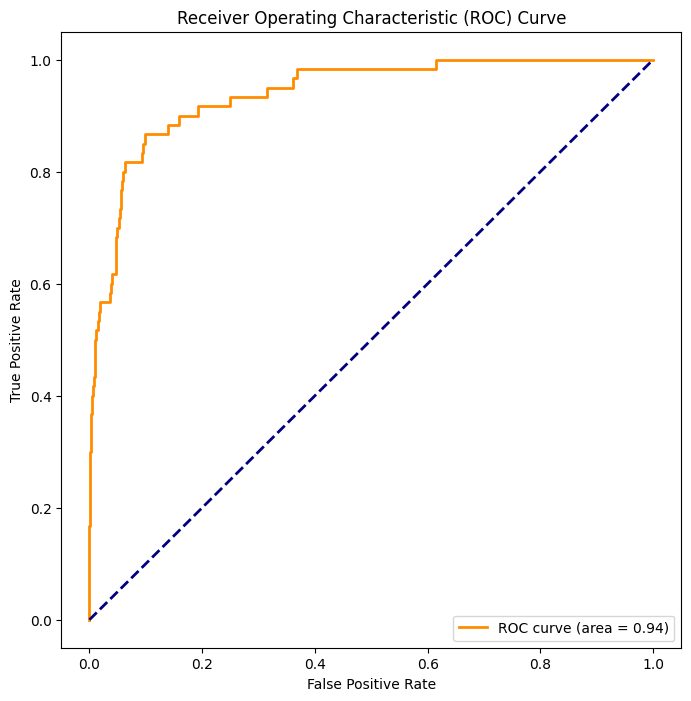

NameError: name 'start_time' is not defined

In [15]:
ConvNeXtLarge = tf.keras.applications.ConvNeXtLarge(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

ConvNeXtLarge= model_training(ConvNeXtLarge,'ConvNeXtLarge.h5', 30)

In [24]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.applications.convnext import ConvNeXtLarge

# Load the model.
model = tf.keras.models.load_model('ConvNeXtLarge.h5')

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (299, 299))
input_image = tf.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)
input_image = input_image.numpy()

# Make a prediction on the preprocessed image.
start_time = time.time()
prediction = model.predict(input_tensor=input_image)
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


ValueError: Unknown layer: 'LayerScale'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [25]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.applications.convnext import ConvNeXtLarge
from tensorflow.keras.layers import Masking

# Load the model.
model = ConvNeXtLarge(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (299, 299))
input_image = tf.expand_dims(input_image, axis=0)
input_image = preprocess_input(input_image)
input_image = input_image.numpy()

# Mask the preprocessed input image.
masking_layer = Masking()
masked_input_image = masking_layer(input_image)

# Make a prediction on the masked input image.
start_time = time.time()
prediction = model.call([masked_input_image])
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


Inference time: 4039.808511734009


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('ConvNeXtLarge.h5')

# Now, 'loaded_model' contains the trained ConvNeXtLarge model.


In [ ]:
EfficientNetV2L = tf.keras.applications.EfficientNetV2L(weights='imagenet', include_top=False, input_tensor=None, input_shape=None)

EfficientNetV2L= model_training(EfficientNetV2L,'EfficientNetV2L.h5', 30)

473176280/473176280 [==============================] - 2s 0us/step


In [29]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L

# Load the model.
model = tf.keras.models.load_model('EfficientNetV2L.h5')

# Preprocess the input image.
input_image = np.array(tf.keras.preprocessing.image.load_img('/kaggle/input/wheat-prepo-data/wheat-data-prepo/train/Wheat__septoria/los(10).JPG'))
input_image = tf.image.resize(input_image, (224, 224))
input_image = tf.expand_dims(input_image, axis=0)
input_image = input_image / 255.0

# Make a prediction on the preprocessed image.
start_time = time.time()
prediction = model.call(input_image)
end_time = time.time()

# Calculate the inference time in milliseconds.
inference_time_ms = (end_time - start_time) * 1000

# Print the inference time in milliseconds.
print('Inference time:', inference_time_ms)


Inference time: 778.6746025085449
